In [ ]:
from dotenv import load_dotenv

load_dotenv()

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

# Simple LLM Chain

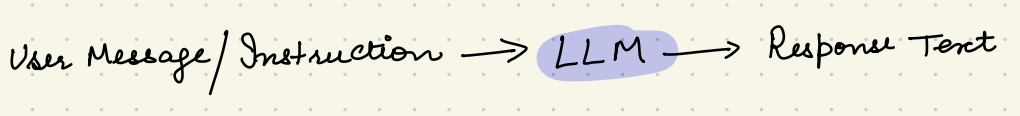

In [ ]:
prompt = """Write me a short poem of 4 lines for my dog."""
response = llm.invoke(prompt)
response.content

# LLM Chain with extra context

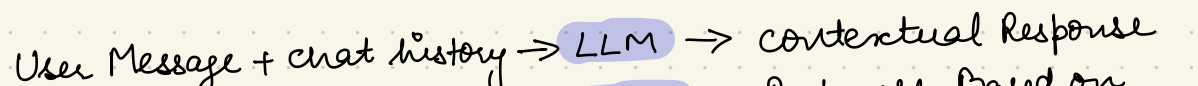

In [ ]:
response = llm.invoke("Who am I?")
response.content

In [ ]:
from langchain.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("user", "Hi, I am Pulkit."),
    ("assistant", "Hello Pulkit! How can I assist you today?"),
    ("user", "{input}"),])
response = llm.invoke(prompt.format(input="Who am I?"))
response.content

# Single turn function/tool calling

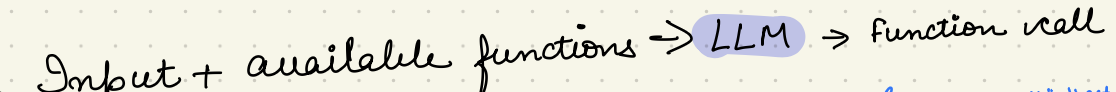

In [ ]:
from langchain_core.tools import tool

@tool
def get_price(product_name : str) -> str:
    """Get the price of a product."""
    return f"The price of {product_name} is $199.00."

@tool
def is_available(product_name : str) -> str:
    """Check if a product is available."""
    return f"{product_name} is available in stock."

tools = [get_price, is_available]

llm_with_tools = llm.bind_tools(tools)
response = llm_with_tools.invoke("What is the price of Airpods Pro?")
response.content

In [ ]:
response.additional_kwargs

In [ ]:
response = llm_with_tools.invoke("Is iPhone 14 available?")
response

In [ ]:
response = llm_with_tools.invoke("What is the price of iPhone 14? Is it available?")
response

In [ ]:
response.additional_kwargs

# Using loops to execute functions

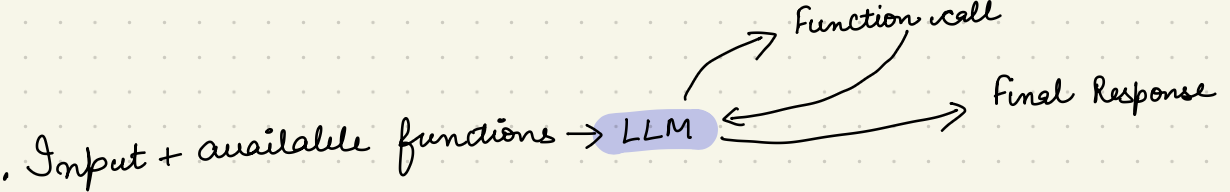

In [ ]:
import json

# Helper function to find a tool by name
def find_tool_by_name(tool_name):
    for tool in tools:
        if tool.name == tool_name:
            return tool
    return None

if(response.additional_kwargs["tool_calls"]):
    for call in response.additional_kwargs["tool_calls"]:
        tool_name = call['function']['name']
        print(f"Tool Name: {tool_name}")
        # call tool
        tool_args = json.loads(call['function']['arguments'])
        tool_function = find_tool_by_name(tool_name)
        tool_response = tool_function.invoke(input = tool_args)
        print(f"Tool Response: {tool_response}")

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("user", "{input}"),
    ("ai", "tool_called: get_price"),
    ("ai", "tool_response: The price of iPhone 14 is $999.00"),
    ("ai", "tool_called: is_available"),
    ("ai", "tool_response: True"),])
response = llm.invoke(prompt.format(input="What is the price of iPhone 14? Is it available?"))
response.content

# Putting it all together -> Agent

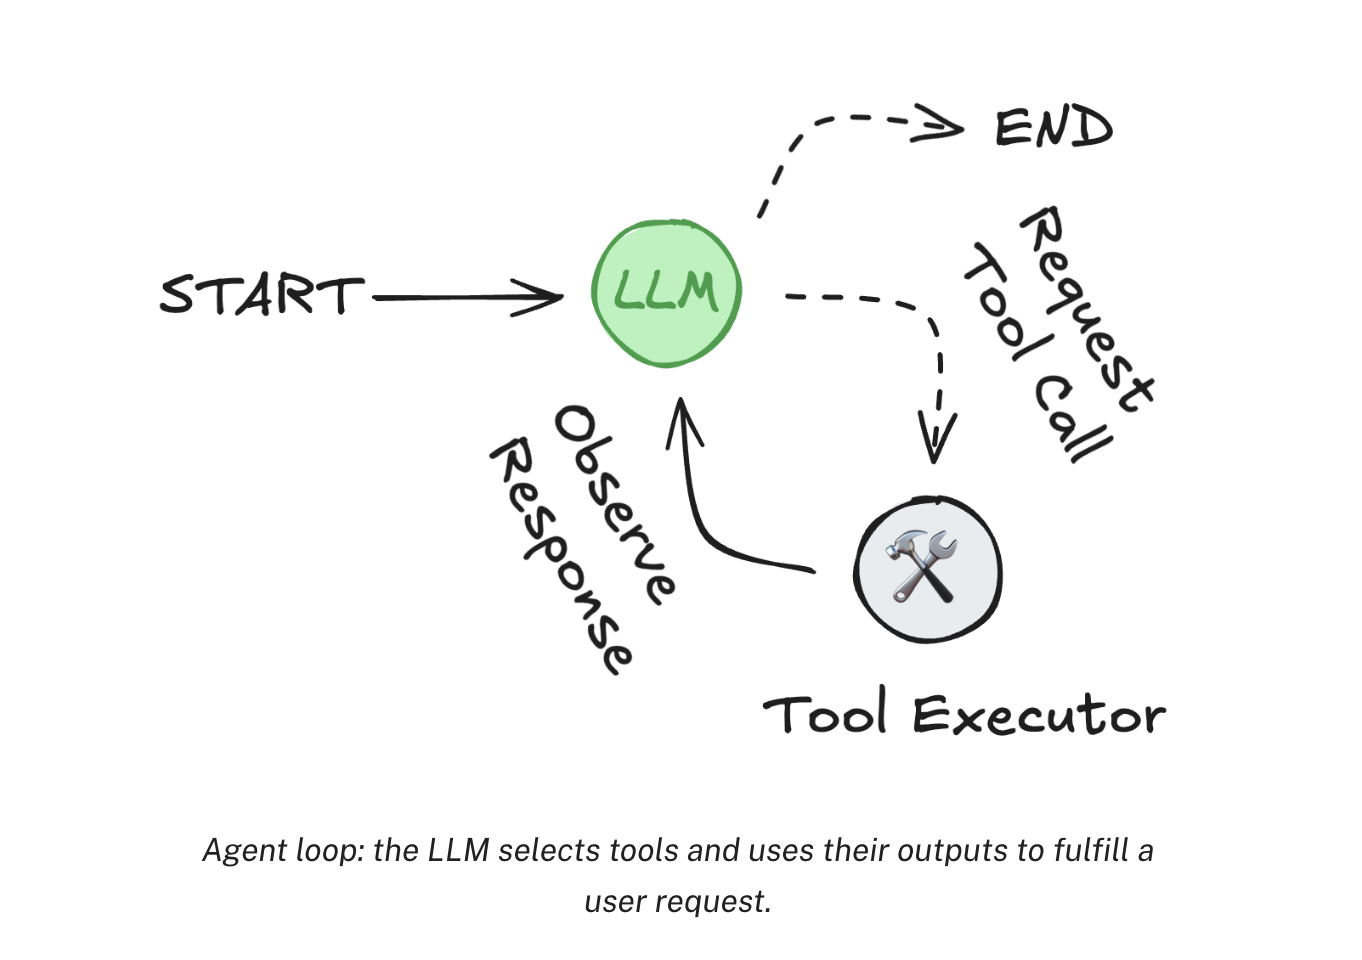

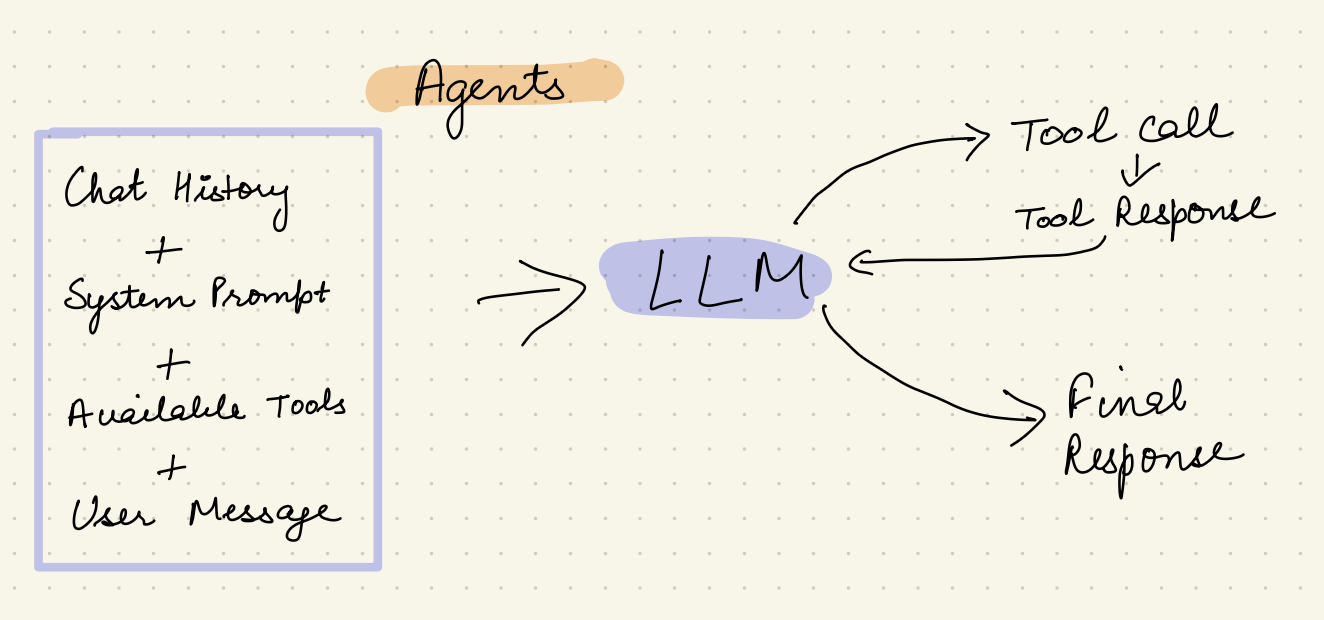

In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

agent = create_react_agent(
    model=llm,
    tools=tools,
    checkpointer=checkpointer,
    debug=True,) 

config = {
    "configurable": {
        "thread_id": "1"  
    }
}


In [ ]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
agent_response = agent.invoke({"messages":[{"role": "user", "content": "I want to buy an iPhone 14"}]}, config)


In [ ]:
agent_response['messages'][-1].content